# So what?

In [186]:
import sympy as sp
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex = True)

In [187]:
S_Pr_Tr = sp.Symbol("S(Pr, Tr)")
G_Pr_T  = sp.Symbol("G(Pr, T)")
G0,T,T_r = sp.symbols('G_0, T, T_r')
c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8 = sp.symbols('c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8')
b_1, b_5, b_6, b_7, b_8                = sp.symbols('b_1, b_5, b_6, b_7, b_8')

## Heat capacity at a given temperature and 1 bar

In Holland and Powell datasets, the heat capacity is expressed as the following polinomial with only $c_1$ to $c_5$ terms

$$ C_p = c_1 +c_2T +\frac{c_3}{T^2} + c_4T^2 + \frac{c_5}{\sqrt{T}} + \frac{c_6}{T} + \frac{c_7}{T^3} + c_8T^3 $$



Let's evaluate this for the case of forsterite in hp02ver.dat. It compares well (to the forth decima) with the value retrieved from frendly (175.0651)

In [188]:
def Cp(T):
    return c_1 +c_2*T +c_3/T**2 + c_4*T**2 + c_5/sp.sqrt(T) + c_6/T + c_7/T**3 + c_8*T**3
Cp(1000).subs({c_1:233.3, c_2:.1494E-2, c_3:-603800, c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}).evalf().round(4)

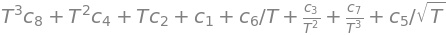

In [189]:
Cp(T)

## Entropy at a given temperature and 1 bar
We can now integrate the symbolic expression to compute the intregal $C_P/T$

In [190]:
CpoT_int = sp.integrate(Cp(T)/T,(T,T_r,T))

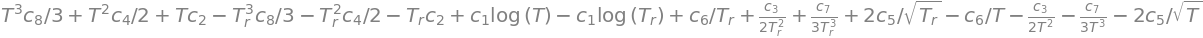

In [191]:
CpoT_int

In [192]:
fo = {'G0':-2053138, 'S0': 95.1, 'V0': 4.366}

We lambdify the expression to make it faster

In [193]:
int_CpoT = sp.lambdify(T, CpoT_int.subs({T_r:298.15, c_1:233.3, c_2:.1494E-2, c_3:-603800, 
                                       c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}), modules='sympy')
int_CpoT(1000).evalf()

and then finally we compute the entropy at 1 bar by adding the reference entropy. That compares with the frendly value (277.0713 J/mol/K)

In [194]:
fo_S = fo.get('S0') + int_CpoT(1000)
fo_S.evalf()

## Apparent gibbs enery at a given temperature and 1 bar

We can do similarly with enthalpy

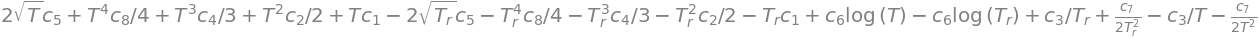

In [195]:
Cp_int   = sp.integrate(Cp(T),(T,T_r,T))
Cp_int

In [196]:
int_Cp   = sp.lambdify(T, Cp_int.subs({T_r:298.15, c_1:233.3, c_2:.1494E-2, c_3:-603800, 
                                       c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}))

In [197]:
def fo_G(T): 
    T_r = 298.15
    return(fo.get('G0') + fo.get('S0')*(T_r-T) - T*int_CpoT(T) + int_Cp(T))

that compares also very well with the value from frendly (-2192536 J/mol)

In [198]:
fo_G(1000).evalf()

## Apparent gibbs enery at a given temperature and pressure
### Volume at high pressure using the Murnaghan equation
It suffices to add to the above expression the volume integral
Holland and Powell expression
$$ \alpha_T = a^0 \left( 1 - \frac{10}{\sqrt(T)} \right) $$
$$ v(T,1) = v^0 [1 + a^0(T-T_r)-20a^0(\sqrt T-\sqrt T_r)] $$

in Perplex these are written as
$$ \alpha (T,P_r) = b_1 + b_5/\sqrt T $$

In [199]:
alpha, beta, kappa, kappa1, P, v, t, v_0 = sp.symbols("alpha, beta, \kappa, \kappa', P, v, t, v_0",
                                                     positive=True, real=True)

In [200]:
def alpha_T(T):
    return b_1 + b_5/sp.sqrt(T)

def alpha_T_int(t):
    return sp.integrate(alpha_T(t),(t,T_r,T))

def v_1(T): 
    return v_0.subs({v_0:4.366})*(1 + sp.integrate(alpha_T(t),(t,T_r,T)).subs({t:1000, b_1:.613E-4, b_5:-.613E-3})).evalf()

$$ V(T,P_r) = V_0·\left [1 + \int_{T_r}^{T}\alpha(T,P_r)dT \right] $$

In [201]:
T_r = 298.15
v_1(1000).round(6)

that compares with the frendly value 4.476770 J/mol/bar

In [258]:
def alpha_T(T):
    return b_1 + b_5/sp.sqrt(T)

def alpha_T_int(t):
    return sp.integrate(alpha_T(t),(t,T_r,T))

def v_1(T): 
    return v_0*(1 + sp.integrate(alpha_T(t),(t,T_r,T))).evalf()

v_1(T)

compresibility (1/bar) $\equiv v_0/\beta$
expansivity (1/K) $\equiv v_0*\alpha_T$

In [202]:
expansivity = 4.366*alpha_T(1000).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()
expansivity

that compares with the frendly value (0.1829078E-03 1/K) at 1 bar 1000 K

$$K(T,P_r) = b_6 + b_7·(T-T_r) $$

Molar volume at T and P
$$ v(T,P) = v(T,1)\left [ 1-\frac{4P}{\kappa_T + 4P} \right]^{1/4} $$

In [259]:
def kappa(T):
    return b_6 + b_7*(T-T_r)

In [260]:
def v(T,P):
    return v_1(T)*(1-4*P/(kappa(T)+ 4*P))**(1/4)

In [273]:
T_r = 298.15
v(1000,1000).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

that compares well with the value of frendly 4.437839 J/mol/bar

### Contribution of the volume at P and T to the gibbs energy 

$$ \int_1^PV(T,P)dP= \frac{V(T,1)K_T}{3}\left [\left (1+\frac{4P}{K_T} \right)^{3/4}-1 \right]$$

In [252]:
def int_v(T,P):
    return v_1(T)*kappa(T)/3*((1+4*P/kappa(T))**(3/4)-1)

v_1(T)

# symbolic volume integral

In [263]:
int_v(T,P)

In [265]:
int_vdP = v_1(T)*kappa(T)/3*((1+4*P/kappa(T))**(3/4)-1)
int_vdP

In [267]:
def fo_G(T, P): 
    return fo.get('G0') + fo.get('S0')*(T_r-T) - T*int_CpoT(T) + int_Cp(T) + int_v(T,P)

In [268]:
fo_G(1000,10000).subs({v_0:4.331754, b_6:1250000, b_7:-109.5}).round()

TypeError: Cannot round symbolic expression

that comapares quite well with the value from frendly -2147968 J

# All together now

Below a more condensed expression to compute the gibbs energy of an end-member, though not very elegant. 

In [211]:
import sympy as sp
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex = True)

T_r = 298.15

S_Pr_Tr = sp.Symbol("S(Pr, Tr)")
G0,S0, T, P, T_r = sp.symbols('G_0, S0, T, P, T_r')

c_1, c_2, c_3, c_5 = sp.symbols('c_1, c_2, c_3, c_5')
b_1, b_5, b_6, b_7 = sp.symbols('b_1, b_5, b_6, b_7')
alpha, beta, kappa, P, v_0  = sp.symbols("alpha, beta, \kappa, P, v_0")

def Cp(T):
    return c_1 +c_2*T +c_3/T**2 + c_5/sp.sqrt(T)

In [212]:
def G(t,p,phase):

    CpoT_int = sp.integrate(Cp(T)/T,(T,T_r,T)).subs({c_1:phase.get('c_1'), 
                                                 c_2:phase.get('c_2'), 
                                                 c_3:phase.get('c_3'), 
                                                 c_5:phase.get('c_5')})

    Cp_int   = sp.integrate(Cp(T),(T,T_r,T)).subs({c_1:phase.get('c_1'), 
                                               c_2:phase.get('c_2'), 
                                               c_3:phase.get('c_3'), 
                                               c_5:phase.get('c_5')})


    alpha_T_int = (sp.integrate(phase.get('b_1') 
                                + phase.get('b_5')/sp.sqrt(T),(T,T_r,T)))
    
    v_1         = phase.get('V0')*(1 + alpha_T_int)
    kappa       = phase.get('b_6') + phase.get('b_7')*(T-T_r)

    int_v       = v_1*kappa/3*((1+4*P/kappa)**(3/4)-1)
    return (phase.get('G0') + phase.get('S0')*(T_r-t) - t*CpoT_int.subs({T:t}) + Cp_int.subs({T:t}) 
            + int_v.subs({T:t,P:p}))

## Symbolic expression for G

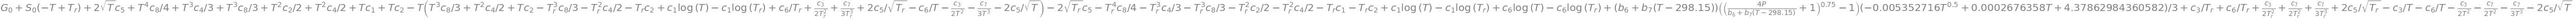

In [213]:
Gs = G0 + S0*(T_r-T) + CpoT_int - T*CpoT_int + Cp_int + int_vdP
Gs

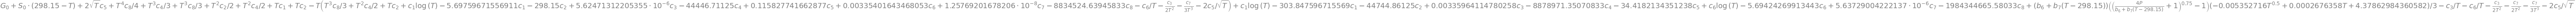

In [222]:
Gs.subs({T_r : 298.15})

In [223]:
print(Gs.subs({T_r : 298.15}))

G_0 + S0*(298.15 - T) + 2*sqrt(T)*c_5 + T**4*c_8/4 + T**3*c_4/3 + T**3*c_8/3 + T**2*c_2/2 + T**2*c_4/2 + T*c_1 + T*c_2 - T*(T**3*c_8/3 + T**2*c_4/2 + T*c_2 + c_1*log(T) - 5.69759671556911*c_1 - 298.15*c_2 + 5.62471312205355e-6*c_3 - 44446.71125*c_4 + 0.115827741662877*c_5 + 0.00335401643468053*c_6 + 1.25769201678206e-8*c_7 - 8834524.63945833*c_8 - c_6/T - c_3/(2*T**2) - c_7/(3*T**3) - 2*c_5/sqrt(T)) + c_1*log(T) - 303.847596715569*c_1 - 44744.86125*c_2 + 0.00335964114780258*c_3 - 8878971.35070833*c_4 - 34.4182134351238*c_5 + c_6*log(T) - 5.69424269913443*c_6 + 5.63729004222137e-6*c_7 - 1984344665.58033*c_8 + (b_6 + b_7*(T - 298.15))*((4*P/(b_6 + b_7*(T - 298.15)) + 1)**0.75 - 1)*(-0.005352716*T**0.5 + 0.0002676358*T + 4.37862984360582)/3 - c_3/T - c_6/T - c_3/(2*T**2) - c_7/(2*T**2) - c_7/(3*T**3) - 2*c_5/sqrt(T)


## With all parameters

In [246]:
def g(T,P,phase):
    return (
    phase.get('G0') + 
    phase.get('S0')*(298.15 - T)  +
    2*np.sqrt(T)*phase.get('c_5') + 
    T**4*phase.get('c_8')   + 
    T**3*phase.get('c_4')/3 + 
    T**3*phase.get('c_8')/3 + 
    T**2*phase.get('c_2')/2 + 
    T**2*phase.get('c_4')/2 + 
    T*phase.get('c_1') + 
    T*phase.get('c_2') - 
    T*(T**3*phase.get('c_8')/3 + T**2*phase.get('c_4')/2 + 
       T*phase.get('c_2') + phase.get('c_1')*np.log(T) - 
       5.69759671556911*phase.get('c_1')    - 298.15*phase.get('c_1') + 
       5.62471312205355e-6*phase.get('c_3') - 44446.71125*phase.get('c_4') + 
       0.115827741662877*phase.get('c_5')   + 0.00335401643468053*phase.get('c_6') + 
       1.25769201678206e-8*phase.get('c_7') - 8834524.63945833*phase.get('c_8')    - 
       phase.get('c_6')/T - phase.get('c_3')/(2*T**2) - phase.get('c_7')/(3*T**3)  - 
       2*phase.get('c_5')/np.sqrt(T))    + 
    phase.get('c_1')*np.log(T)           - 
    303.847596715569*phase.get('c_1')    - 
    44744.86125*phase.get('c_2')         + 
    0.00335964114780258*phase.get('c_3') - 
    8878971.35070833*phase.get('c_4')    - 
    34.4182134351238*phase.get('c_5')    + 
    phase.get('c_6')*np.log(T)           - 
    5.69424269913443*phase.get('c_6')    + 
    5.63729004222137e-6*phase.get('c_7') - 
    1984344665.58033*phase.get('c_8')    + 
    (phase.get('c_6') + phase.get('c_7')*(T - 298.15))                      * 
    ((4*P/(phase.get('c_6') + phase.get('c_7')*(T - 298.15)) + 1)**0.75 -1) *
    (-0.005352716*T**0.5 + 0.0002676358*T + 4.37862984360582)/3             - 
    phase.get('c_3')/T        - 
    phase.get('c_6')/T        - 
    phase.get('c_3')/(2*T**2) - 
    phase.get('c_7')/(2*T**2) - 
    phase.get('c_7')/(3*T**3) - 
    2*phase.get('c_5')/np.sqrt(T)
    )


In [248]:
fo = {'G0' :-2053138, 
      'S0' : 95.1, 
      'V0' : 4.366, 
      'c_1': 233.3, 'c_2':.1494E-2, 'c_3':-603800, 'c_5':-1869.7, 
      'b_1':.613E-4,'b_5':-.613E-3, 'b_6':1250000, 'b_7':-109.5,
      'c_4': 0     ,'c_6':  0     , 'c_7':0      , 'c_8':0     ,
      'b_8': 0
     }

In [251]:
G(1000,1,fo).evalf().subs({T_r : 298.15})

In [250]:
g(1000,1,fo)